<a href="https://colab.research.google.com/github/marcosmedvescig/thesis_survival_models_for_predicting_churn/blob/master/apply_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying model to business solution

## Install libraries

Note: After installing the libraries for the first time restart the runtime for the new versions of the library to be loaded.

In [1]:
## Install libraries
!pip install pysurvival=='0.1.2'
!pip install scikit-survival=='0.13.1'
!pip install osqp=='0.5.0'

     |████████████████████████████████| 4.8MB 2.7MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl size=3774928 sha256=47fad792e7bd4b1b1600e3f39efe924f889132763d1bdae326c8118de3d975a3
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=09d90db7ef723ba9fa802dcd8395080164494576fa2d0a5cdb44f965bbcc8673
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar
     |████████████████████████████████| 1.8MB 2.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 153kB 16.7MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.13.1-cp36-cp36m-linux_x86_64.whl size=4119271 sha256=fc768

## Load Data

In [3]:
import pandas as pd
import numpy as np
import os

# Open dataset
raw_data = pd.read_csv('https://github.com/marcosmedvescig/thesis_survival_models_for_predicting_churn/raw/master/churn_data_anonymized_20200718.csv')
raw_data.rename(columns={'survival_days': 'time', 'status': 'event'},inplace=True)

raw_data.head()

,store_id,time,event,country,max_segment,creation_platform,products_created,admin_visits,source,seller_probability,tx,gmv_usd
0,1842269723731683560,261,1,A,B,A,-0.080154,-0.161978,I,1.014303,-0.042809,-0.071061
1,4773050910207726165,107,1,A,C,A,0.012447,0.566017,I,-0.214408,-0.076793,-0.092084
2,4171477716070775996,102,0,C,A,A,-0.075205,2.295003,A,-0.467481,0.602888,0.209250
3,-558102186785033374,101,1,C,C,A,-0.078033,-0.935472,A,-0.574383,-0.110777,-0.106463
4,-2987486431769169084,444,0,A,B,A,-0.063189,0.611516,I,1.614260,-0.099449,-0.103126


## Create Train, Test and Eval datasets

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Remove observations according to EDA

raw_data = raw_data[raw_data['time']>=0]
raw_data = raw_data[raw_data['products_created'] <= (raw_data['products_created'].mean() + 3 * raw_data['products_created'].std())]
raw_data = raw_data[raw_data['admin_visits'] <= (raw_data['admin_visits'].mean() + 3 * raw_data['admin_visits'].std())]
raw_data = raw_data[raw_data['tx'] <= (raw_data['tx'].mean() + 3 * raw_data['tx'].std())]
raw_data = raw_data[raw_data['gmv_usd'] <= (raw_data['gmv_usd'].mean() + 3 * raw_data['gmv_usd'].std())]

raw_data.reset_index(drop=True,inplace=True)

# Defining the features

X = pd.get_dummies(raw_data.drop(['store_id','time', 'event'], axis=1))
T = raw_data['time']
E = raw_data['event']

## Create evaluation set, 70% of the raw_data.
index_train_test, index_eval = train_test_split( range(len(raw_data)), test_size = 0.7, random_state = 2020)

# Creating the X, T and E input
X_train_test = X.loc[index_train_test].reset_index( drop = True )
X_eval  = X.loc[index_eval].reset_index( drop = True )

T_train_test = T.loc[index_train_test].reset_index( drop = True )
T_eval  = T.loc[index_eval].reset_index( drop = True )

E_train_test = E.loc[index_train_test].reset_index( drop = True )
E_eval  = E.loc[index_eval].reset_index( drop = True )


## Create train and test set, 30% of the raw_data.
index_train, index_test = train_test_split( range(len(X_train_test)), test_size = 0.25, random_state = 2020)

# Creating the X, T and E input
X_train = X_train_test.loc[index_train].reset_index( drop = True )
X_test  = X_train_test.loc[index_test].reset_index( drop = True )

T_train = T_train_test.loc[index_train].reset_index( drop = True )
T_test  = T_train_test.loc[index_test].reset_index( drop = True )

E_train = E_train_test.loc[index_train].reset_index( drop = True )
E_test  = E_train_test.loc[index_test].reset_index( drop = True )

## Risk groups


### Train the model

In [5]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
import pandas as pd

#Creating an instance of the Conditional model and fitting the data.

## Build the model
model = RandomSurvivalForestModel(num_trees=50)
model.fit(X_train, T_train, E_train,
        max_features="sqrt", max_depth=5, min_node_size=5)

RandomSurvivalForestModel

### Create the risk groups

In [21]:
# Define targets

print('Total observations: {}'.format(len(X_eval)))
print('Target low risk group (80%):{}'.format(len(X_eval)*0.8))
print('Target mid risk group (15%):{}'.format(len(X_eval)*0.15))
print('Target high risk group (5%):{}'.format(len(X_eval)*0.05))

Total observations: 2335
Target low risk group (80%):1868.0
Target mid risk group (15%):350.25
Target high risk group (5%):116.75


#### Test 1

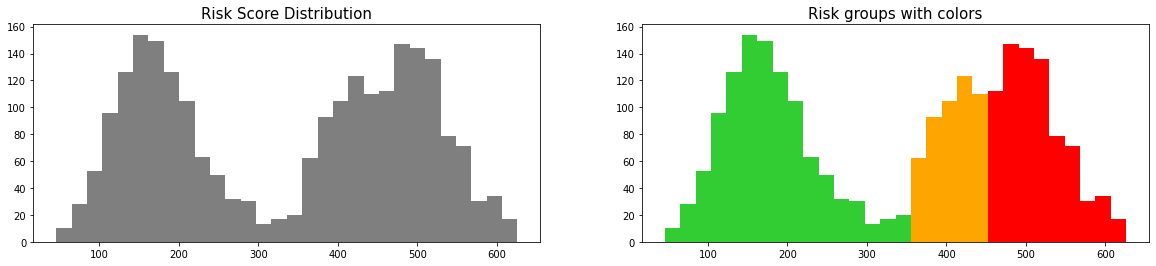

Test 1 - low_upper_bound:350 - mid_upper_bound:450
Low risk group - target: 1868 - current:1052
mid risk group - target: 350 - current:403
high risk group - target: 116 - current:880


In [27]:
from pysurvival.utils.display import create_risk_groups

low_upper_bound = 350
mid_upper_bound = 450

risk_groups = create_risk_groups( model=model, X=X_eval,
                                  use_log = False, num_bins=30, figure_size=(20, 4),
                                  low={'lower_bound':0, 'upper_bound':low_upper_bound, 'color':'limegreen'},
                                  medium={'lower_bound':low_upper_bound, 'upper_bound':mid_upper_bound,'color':'orange'},
                                  high={'lower_bound':mid_upper_bound, 'upper_bound':800,  'color':'red'}
                                  )

print('Test 1 - low_upper_bound:{} - mid_upper_bound:{}'.format(low_upper_bound, mid_upper_bound))
print('Low risk group - target: 1868 - current:{}'.format(len(risk_groups['low'][1])))
print('mid risk group - target: 350 - current:{}'.format(len(risk_groups['medium'][1])))
print('high risk group - target: 116 - current:{}'.format(len(risk_groups['high'][1])))

#### Test 2

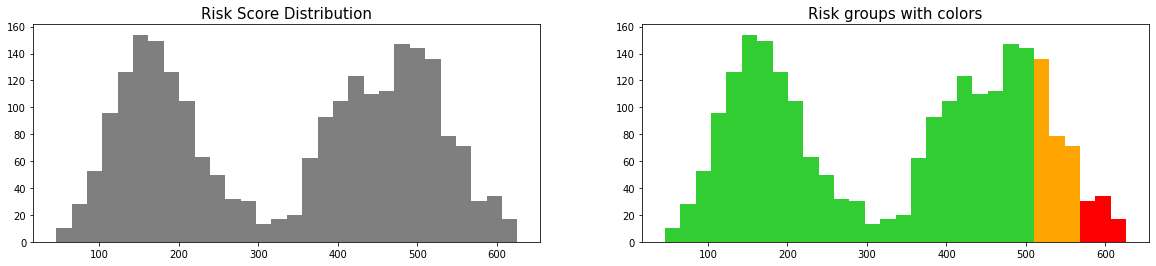

Test 2 - low_upper_bound:510 - mid_upper_bound:560
Low risk group - target: 1868 - current:1824
mid risk group - target: 350 - current:359
high risk group - target: 116 - current:152


In [32]:
from pysurvival.utils.display import create_risk_groups

low_upper_bound = 510
mid_upper_bound = 560

risk_groups = create_risk_groups( model=model, X=X_eval,
                                  use_log = False, num_bins=30, figure_size=(20, 4),
                                  low={'lower_bound':0, 'upper_bound':low_upper_bound, 'color':'limegreen'},
                                  medium={'lower_bound':low_upper_bound, 'upper_bound':mid_upper_bound,'color':'orange'},
                                  high={'lower_bound':mid_upper_bound, 'upper_bound':800,  'color':'red'}
                                  )

print('Test 2 - low_upper_bound:{} - mid_upper_bound:{}'.format(low_upper_bound, mid_upper_bound))
print('Low risk group - target: 1868 - current:{}'.format(len(risk_groups['low'][1])))
print('mid risk group - target: 350 - current:{}'.format(len(risk_groups['medium'][1])))
print('high risk group - target: 116 - current:{}'.format(len(risk_groups['high'][1])))

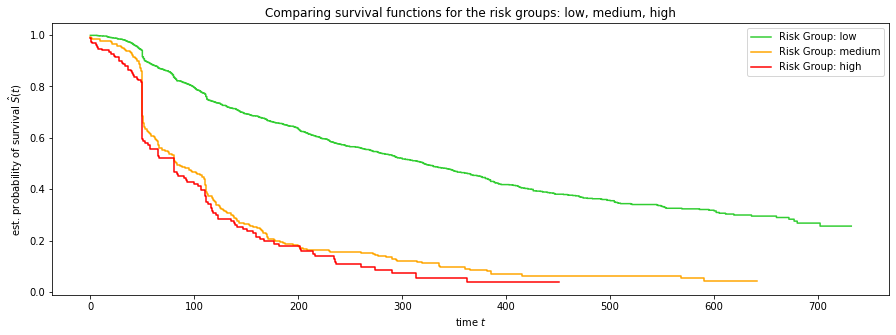

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 5))

for risk_group in ('low','medium','high'):
    time, survival_prob = kaplan_meier_estimator(
        E_eval.iloc[risk_groups[risk_group][1]].astype('bool'),
        T_eval.iloc[risk_groups[risk_group][1]])
    
    plt.step(time, survival_prob, where="post",
            label="Risk Group: %s" % risk_group,
            color = risk_groups[risk_group][0])

plt.title("Comparing survival functions for the risk groups: low, medium, high")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best");

#### Test 3

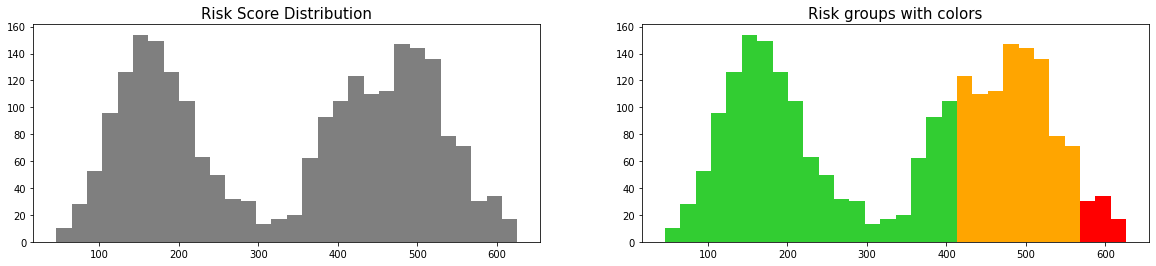

Test 3 - low_upper_bound:400 - mid_upper_bound:560
Low risk group - target: 1868 - current:1227
mid risk group - target: 350 - current:956
high risk group - target: 116 - current:152


In [38]:
from pysurvival.utils.display import create_risk_groups

low_upper_bound = 400
mid_upper_bound = 560

risk_groups = create_risk_groups( model=model, X=X_eval,
                                  use_log = False, num_bins=30, figure_size=(20, 4),
                                  low={'lower_bound':0, 'upper_bound':low_upper_bound, 'color':'limegreen'},
                                  medium={'lower_bound':low_upper_bound, 'upper_bound':mid_upper_bound,'color':'orange'},
                                  high={'lower_bound':mid_upper_bound, 'upper_bound':800,  'color':'red'}
                                  )

print('Test 3 - low_upper_bound:{} - mid_upper_bound:{}'.format(low_upper_bound, mid_upper_bound))
print('Low risk group - target: 1868 - current:{}'.format(len(risk_groups['low'][1])))
print('mid risk group - target: 350 - current:{}'.format(len(risk_groups['medium'][1])))
print('high risk group - target: 116 - current:{}'.format(len(risk_groups['high'][1])))

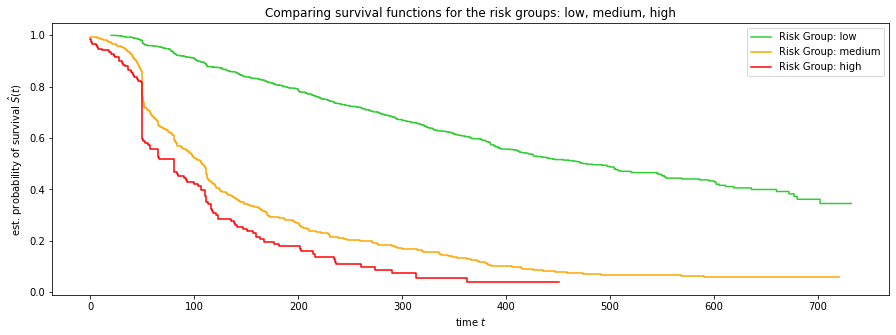

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 5))

for risk_group in ('low','medium','high'):
    time, survival_prob = kaplan_meier_estimator(
        E_eval.iloc[risk_groups[risk_group][1]].astype('bool'),
        T_eval.iloc[risk_groups[risk_group][1]])
    
    plt.step(time, survival_prob, where="post",
            label="Risk Group: %s" % risk_group,
            color = risk_groups[risk_group][0])

plt.title("Comparing survival functions for the risk groups: low, medium, high")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best");

## Performance on risk groups

In [42]:
import pandas as pd
import numpy as np

example = pd.DataFrame()

example['is_churn'] = np.where(E_eval == 1,1,0)
example['lifetime'] = T_eval.to_list()

example['true'] = np.where(example['lifetime'] <= 90,'high',
                          np.where(example['lifetime'] <= 365 ,'mid','low'))

example['pred'] = 'low'
example.iloc[risk_groups['high'][1],example.columns.get_loc('pred')] = 'high'
example.iloc[risk_groups['medium'][1],example.columns.get_loc('pred')] = 'mid'

example.head()

,is_churn,lifetime,true,pred
0,0,295,mid,low
1,0,98,mid,mid
2,1,48,high,mid
3,0,308,mid,low
4,0,261,mid,low


In [43]:

from sklearn.metrics import precision_recall_fscore_support

prec,rec,f1,support = precision_recall_fscore_support(example['true'],example['pred'],pos_label=None,average='weighted')
print('Model - Precision: {0:1.2f} - Recall: {1:1.2f}'.format(prec,rec))

result = precision_recall_fscore_support(example['true'],example['pred'],labels=['high','mid','low'])
print('High Risk - Precision: {0:1.2f} - Recall: {1:1.2f}'.format(result[0][0],result[1][0]))
print('Mid Risk - Precision: {0:1.2f} - Recall: {1:1.2f}'.format(result[0][1],result[1][1]))
print('Low Risk - Precision: {0:1.2f} - Recall: {1:1.2f}'.format(result[0][2],result[1][2]))

Model - Precision: 0.48 - Recall: 0.41
High Risk - Precision: 0.62 - Recall: 0.14
Mid Risk - Precision: 0.46 - Recall: 0.38
Low Risk - Precision: 0.34 - Recall: 0.86


In [44]:
print('Total clients: {0}'.format(len(X_eval)))
print('Clients in high risk group: {0}'.format(len(X_eval.iloc[risk_groups['high'][1]])))
print('Clients in mid risk group: {0}'.format(len(X_eval.iloc[risk_groups['medium'][1]])))
print('Clients in low risk group: {0}'.format(len(X_eval.iloc[risk_groups['low'][1]])))

r_high_v_high = len(X_eval.iloc[risk_groups['high'][1]].loc[X_eval['gmv_usd'] >= X_eval['gmv_usd'].mean()])
r_high_v_low = len(X_eval.iloc[risk_groups['high'][1]].loc[X_eval['gmv_usd'] < X_eval['gmv_usd'].mean()])
r_mid_v_high = len(X_eval.iloc[risk_groups['medium'][1]].loc[X_eval['gmv_usd'] >= X_eval['gmv_usd'].mean()])
r_mid_v_low = len(X_eval.iloc[risk_groups['medium'][1]].loc[X_eval['gmv_usd'] < X_eval['gmv_usd'].mean()])
r_low_v_high = len(X_eval.iloc[risk_groups['low'][1]].loc[X_eval['gmv_usd'] >= X_eval['gmv_usd'].mean()])
r_low_v_low = len(X_eval.iloc[risk_groups['low'][1]].loc[X_eval['gmv_usd'] < X_eval['gmv_usd'].mean()])

green_group = r_low_v_low + r_low_v_high + r_mid_v_low
yellow_group = r_mid_v_high + r_high_v_low
red_group = r_high_v_high

print('Clients in green group: {0} ({1}%)'.format(green_group,round((green_group /len(X_eval))*100,1)))
print('Clients in yellow group: {0} ({1}%)'.format(yellow_group,round((yellow_group /len(X_eval))*100,1)))
print('Clients in red group: {0} ({1}%)'.format(red_group,round((red_group /len(X_eval))*100,1)))

Total clients: 2335
Clients in high risk group: 152
Clients in mid risk group: 956
Clients in low risk group: 1227
Clients in green group: 2128 (91.1%)
Clients in yellow group: 207 (8.9%)
Clients in red group: 0 (0.0%)
